# Load EIA natural gas and coal prices for electric power plants in Texas
These values are real (not adjusted for inflation)

I forgot that we don't have 2007 coal price data. Applying the average 2008 price for now.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import re
import cPickle as pickle
import gzip
import seaborn as sns

/Users/Home/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Natural gas
Price is $/thousand cubic feet (mcf)

In [4]:
path = os.path.join('EIA data', 'Natural gas price', 'N3045TX3m.xls')
ng_price = pd.read_excel(path, sheetname='Data 1', header=2)

In [5]:
ng_price.head()

,Date,Texas Natural Gas Price Sold to Electric Power Consumers (Dollars per Thousand Cubic Feet)
0,2002-01-15,2.65
1,2002-02-15,2.36
2,2002-03-15,2.96
3,2002-04-15,3.57
4,2002-05-15,3.52


In [6]:
ng_price.dtypes

Date                                                                                          datetime64[ns]
Texas Natural Gas Price Sold to Electric Power Consumers (Dollars per Thousand Cubic Feet)           float64
dtype: object

In [8]:
ng_price.rename(columns={"Texas Natural Gas Price Sold to Electric Power Consumers (Dollars per Thousand Cubic Feet)":
                         "NG Price ($/mcf)"}, inplace=True)

In [9]:
ng_price.head()

,Date,NG Price ($/mcf)
0,2002-01-15,2.65
1,2002-02-15,2.36
2,2002-03-15,2.96
3,2002-04-15,3.57
4,2002-05-15,3.52


In [12]:
ng_price.loc[:,'Month'] = ng_price.loc[:,'Date'].apply(lambda x: x.month)
ng_price.loc[:,'Year'] = ng_price.loc[:,'Date'].apply(lambda x: x.year)

In [13]:
ng_price.head()

,Date,NG Price ($/mcf),Month,Year
0,2002-01-15,2.65,1,2002
1,2002-02-15,2.36,2,2002
2,2002-03-15,2.96,3,2002
3,2002-04-15,3.57,4,2002
4,2002-05-15,3.52,5,2002


In [55]:
ng_price.dtypes

Date                datetime64[ns]
NG Price ($/mcf)           float64
Month                        int64
Year                         int64
dtype: object

## Coal
Price is $/short ton

### EIA data
[Source](http://www.eia.gov/beta/coal/data/browser/#/topic/45?agg=1,0&geo=vvvvvvvvvvvvo&rank=l&linechart=~~COAL.SHIP_PLANT_PRICE.TX-LIG.Q~COAL.SHIP_PLANT_PRICE.TX-SUB.Q&columnchart=COAL.SHIP_PLANT_PRICE.US-TOT.Q&map=COAL.SHIP_PLANT_PRICE.US-TOT.Q&freq=Q&start=200801&end=201601&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&pin=&rse=0&maptype=0)

In [93]:
path = os.path.join('EIA data', 'Coal prices', 'Texas electric sector coal price.xlsx')
coal_temp = pd.read_excel(path, sheetname='Sheet1')

In [94]:
coal_temp.head()

,Date,All coal,Lignite,Subbituminous
0,Q1 2008,24.32,19.38,26.72
1,Q2 2008,24.94,19.36,28.21
2,Q3 2008,25.91,20.11,29.23
3,Q4 2008,25.42,21.26,28.30
4,Q1 2009,25.92,22.40,27.88


In [95]:
coal_temp.loc[:,'Quarter'] = coal_temp.loc[:,'Date'].apply(lambda x: int(x[1]))
coal_temp.loc[:,'Year'] = coal_temp.loc[:,'Date'].apply(lambda x: int(x[-4:]))

In [96]:
coal_temp.head()

,Date,All coal,Lignite,Subbituminous,Quarter,Year
0,Q1 2008,24.32,19.38,26.72,1,2008
1,Q2 2008,24.94,19.36,28.21,2,2008
2,Q3 2008,25.91,20.11,29.23,3,2008
3,Q4 2008,25.42,21.26,28.30,4,2008
4,Q1 2009,25.92,22.40,27.88,1,2009


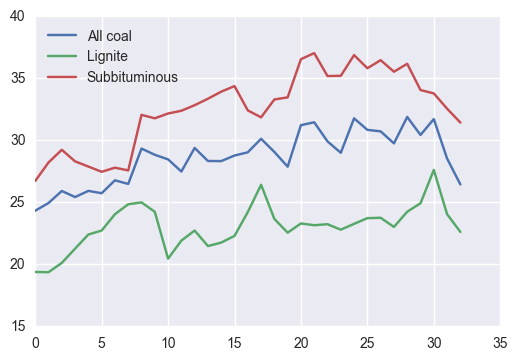

In [99]:
for coal in ['All coal', 'Lignite', 'Subbituminous']:
    plt.plot(coal_temp.index, coal_temp[coal], label=coal)
plt.legend(loc=0)

In [102]:
coal_temp[['All coal', 'Lignite', 'Subbituminous']].corr()

,All coal,Lignite,Subbituminous
All coal,1.00000,0.630680,0.897700
Lignite,0.63068,1.000000,0.327342
Subbituminous,0.89770,0.327342,1.000000


#### Make up data for 2007
The EIA source only goes back to 2008. Use average 2008 price for 2007. If there is time, look for more data or figure out better method.

In [103]:
coal_2007 = pd.DataFrame(columns=coal_temp.columns)

In [104]:
coal_2007['Quarter'] = [1,2,3,4]
coal_2007['Year'] = 2007
for coal in ['All coal', 'Lignite', 'Subbituminous']:
    coal_2007[coal] = coal_temp.loc[coal_temp['Year']==2008,coal].mean()

In [105]:
coal_2007

,Date,All coal,Lignite,Subbituminous,Quarter,Year
0,NaN,25.1475,20.0275,28.115,1,2007
1,NaN,25.1475,20.0275,28.115,2,2007
2,NaN,25.1475,20.0275,28.115,3,2007
3,NaN,25.1475,20.0275,28.115,4,2007


In [106]:
coal_temp = coal_temp.append(coal_2007)

In [107]:
coal_temp.tail()

,Date,All coal,Lignite,Subbituminous,Quarter,Year
32,Q1 2016,26.4400,22.6100,31.430,1,2016
0,NaN,25.1475,20.0275,28.115,1,2007
1,NaN,25.1475,20.0275,28.115,2,2007
2,NaN,25.1475,20.0275,28.115,3,2007
3,NaN,25.1475,20.0275,28.115,4,2007


### Make dataframe with quarter, month, and year columns from 2007-2015

In [108]:
df = pd.DataFrame(pd.date_range('2007-1-15', periods=12*9, freq='M'), columns=['tempdate'])

In [109]:
df.head()

,tempdate
0,2007-01-31
1,2007-02-28
2,2007-03-31
3,2007-04-30
4,2007-05-31


In [110]:
df.loc[:,'Quarter'] = df.loc[:,'tempdate'].apply(lambda x: x.quarter)
df.loc[:,'Month'] = df.loc[:,'tempdate'].apply(lambda x: x.month)
df.loc[:,'Year'] = df.loc[:,'tempdate'].apply(lambda x: x.year)

In [116]:
df.head()
df.tail()

,tempdate,Quarter,Month,Year
0,2007-01-31,1,1,2007
1,2007-02-28,1,2,2007
2,2007-03-31,1,3,2007
3,2007-04-30,2,4,2007
4,2007-05-31,2,5,2007


,tempdate,Quarter,Month,Year
103,2015-08-31,3,8,2015
104,2015-09-30,3,9,2015
105,2015-10-31,4,10,2015
106,2015-11-30,4,11,2015
107,2015-12-31,4,12,2015


In [112]:
coal_price = pd.merge(coal_temp, df, on=['Quarter', 'Year'])

In [113]:
coal_price.head()

,Date,All coal,Lignite,Subbituminous,Quarter,Year,tempdate,Month
0,Q1 2008,24.32,19.38,26.72,1,2008,2008-01-31,1
1,Q1 2008,24.32,19.38,26.72,1,2008,2008-02-29,2
2,Q1 2008,24.32,19.38,26.72,1,2008,2008-03-31,3
3,Q2 2008,24.94,19.36,28.21,2,2008,2008-04-30,4
4,Q2 2008,24.94,19.36,28.21,2,2008,2008-05-31,5


## Combine fuel dataframes

In [114]:
fuel_price = pd.merge(ng_price, coal_price, how='right', on=['Month', 'Year'])

In [115]:
fuel_price.head()

,Date_x,NG Price ($/mcf),Month,Year,Date_y,All coal,Lignite,Subbituminous,Quarter,tempdate
0,2007-01-15,6.42,1,2007,NaN,25.1475,20.0275,28.115,1,2007-01-31
1,2007-02-15,7.34,2,2007,NaN,25.1475,20.0275,28.115,1,2007-02-28
2,2007-03-15,6.90,3,2007,NaN,25.1475,20.0275,28.115,1,2007-03-31
3,2007-04-15,7.29,4,2007,NaN,25.1475,20.0275,28.115,2,2007-04-30
4,2007-05-15,7.51,5,2007,NaN,25.1475,20.0275,28.115,2,2007-05-31


In [117]:
fuel_price.tail()

,Date_x,NG Price ($/mcf),Month,Year,Date_y,All coal,Lignite,Subbituminous,Quarter,tempdate
103,2015-08-15,3.01,8,2015,Q3 2015,31.71,27.61,33.78,3,2015-08-31
104,2015-09-15,2.88,9,2015,Q3 2015,31.71,27.61,33.78,3,2015-09-30
105,2015-10-15,2.66,10,2015,Q4 2015,28.53,24.04,32.55,4,2015-10-31
106,2015-11-15,2.30,11,2015,Q4 2015,28.53,24.04,32.55,4,2015-11-30
107,2015-12-15,2.23,12,2015,Q4 2015,28.53,24.04,32.55,4,2015-12-31


In [118]:
fuel_price.drop(['Date_x', 'Date_y', 'tempdate', 'Quarter'], axis=1, inplace=True)

In [119]:
path = os.path.join('..', 'Clean Data', 'Fuel prices.csv')
fuel_price.to_csv(path)